# Ширење на повторувачки епидемии

Објаснување и равенки

**Имунитет  ЕР, СИР 10 000 јазли**

In [23]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=.75)
from IPython.display import Image



class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)
        
        
N = 10000
kmean = 20

T = 5000

pInfected = 0.01
pInfect = 0.0002   # above the epidemic threshold
pRemove = 0.002


g = networkx.gnp_random_graph(N, (kmean + 0.0) / N)

param = dict()
param[epydemic.SIR.P_INFECTED] = pInfected
param[epydemic.SIR.P_INFECT] = pInfect
param[epydemic.SIR.P_REMOVE] = pRemove
param[epydemic.Monitor.DELTA] = T / 50


m1 = MonitoredSIR()
e1 = epydemic.StochasticDynamics(m1, g)
rc1 = e1.set(param).run()


print('Remaining susceptible {s}, removed {r}'.format(s=len(m1.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m1.compartment(epydemic.SIR.REMOVED))))

Remaining susceptible 2405, removed 7595


In [25]:
h = m1.network().copy()
h.remove_nodes_from(m1.compartment(epydemic.SIR.INFECTED))
h.remove_nodes_from(m1.compartment(epydemic.SIR.REMOVED))

In [26]:
print('Order of residual network {o}'.format(o=h.order()))

Order of residual network 2405


In [27]:
m2 = MonitoredSIR()
e2 = epydemic.StochasticDynamics(m2, h)
rc2 = e2.set(param).run()

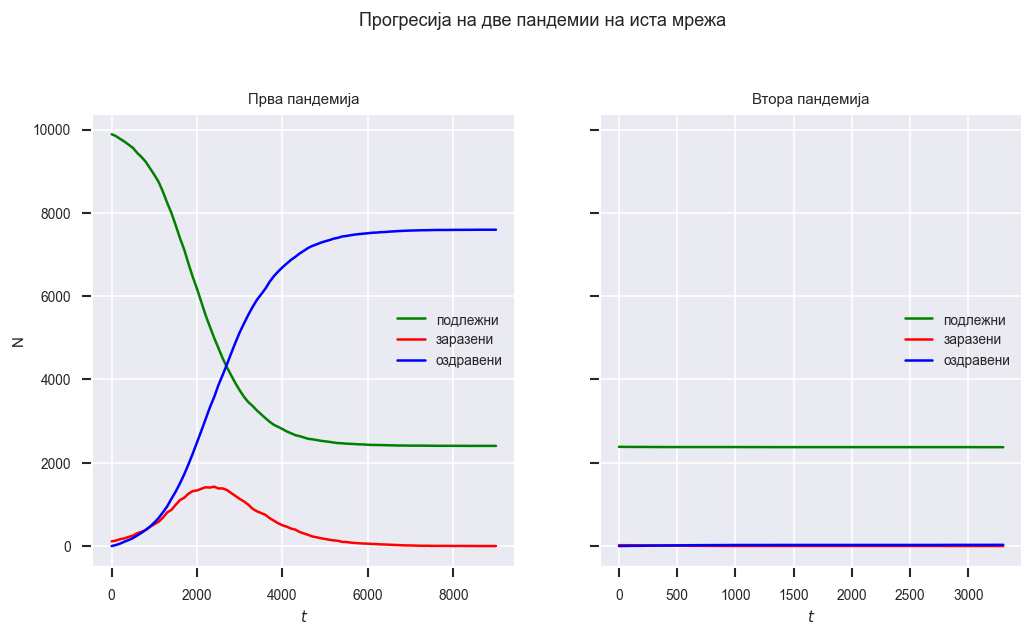

In [28]:
(fig, axs) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

# plot the first epidemic
ax = axs[0]
timeseries1 = rc1[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
ts1 = timeseries1[epydemic.Monitor.OBSERVATIONS]
ss1 = timeseries1[epydemic.SIR.SUSCEPTIBLE]
is1 = timeseries1[epydemic.SIR.INFECTED]
rs1 = timeseries1[epydemic.SIR.REMOVED]
ax.plot(ts1, ss1, 'g-', label='подлежни')
ax.plot(ts1, is1, 'r-', label='заразени')
ax.plot(ts1, rs1, 'b-', label='оздравени')
ax.set_xlabel('$t$')
ax.set_ylabel('N')
ax.set_title('Прва пандемија')
ax.legend(loc='center right')

# plot the second epidemic on the residual network
ax = axs[1]
timeseries2 = rc2[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
ts2 = timeseries2[epydemic.Monitor.OBSERVATIONS]
ss2 = timeseries2[epydemic.SIR.SUSCEPTIBLE]
is2 = timeseries2[epydemic.SIR.INFECTED]
rs2 = timeseries2[epydemic.SIR.REMOVED]
ax.plot(ts2, ss2, 'g-', label='подлежни')
ax.plot(ts2, is2, 'r-', label='заразени')
ax.plot(ts2, rs2, 'b-', label='оздравени')
ax.set_xlabel('$t$')
ax.set_title('Втора пандемија')
ax.legend(loc='center right')

# fine-time the figure
plt.suptitle('Прогресија на две пандемии на иста мрежа', y=1.05)
axs[0].set_ylabel('N')

_ = plt.show()

In [29]:
print('Remaining susceptible {s}, removed {r}'.format(s=len(m2.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m2.compartment(epydemic.SIR.REMOVED))))

Remaining susceptible 2374, removed 31


In [30]:
print('Mean degree of initial network {kmean}'.format(kmean=kmean))
print('Mean degree of residual network {kmean:.2f}'.format(kmean=numpy.mean(list(dict(h.degree()).values()))))

Mean degree of initial network 20
Mean degree of residual network 4.97


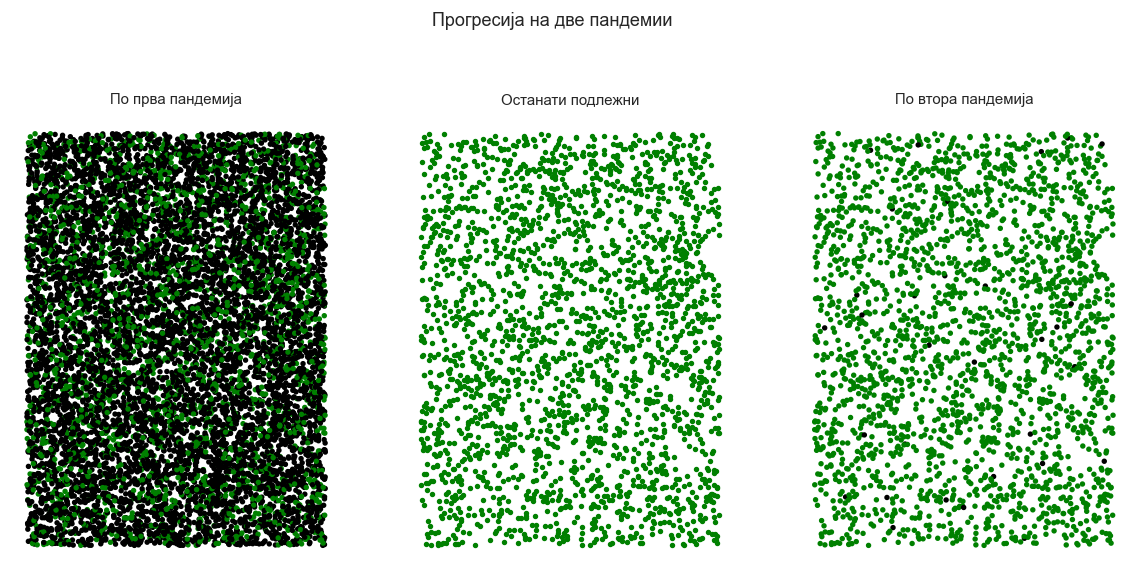

In [32]:
(fig,axs) = plt.subplots(1, 3, figsize=(12, 5))

# colours fgor compartments
colours = dict()
colours[epydemic.SIR.SUSCEPTIBLE] = 'green'
colours[epydemic.SIR.INFECTED] = 'red'
colours[epydemic.SIR.REMOVED] = 'black'

# plot the final network of the first epidemic,
# colouring for compartment
ax = axs[0]
final = m1.network()
pos1 = networkx.drawing.layout.random_layout(final)
ncs = [ colours[m1.getCompartment(n)] for n in final.nodes() ]
networkx.draw_networkx(final, pos=pos1, ax=ax,
                       node_color=ncs, node_size=5,
                       with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('По прва пандемија')

# plot residual network for the second epidemic
ax = axs[1]
final = m2.network()
pos2 = { n: pos1[n] for n in pos1.keys() if n in final.nodes() }
networkx.draw_networkx(final, pos=pos2, ax=ax,
                       node_color=colours[epydemic.SIR.SUSCEPTIBLE],
                       node_size=5, with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('Останати подлежни')

# plot the final network of the second epidemic
ax = axs[2]
ncs = [ colours[m2.getCompartment(n)] for n in final.nodes() ]
networkx.draw_networkx(final, pos=pos2, ax=ax,
                       node_color=ncs, node_size=5,
                       with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('По втора пандемија')

# fine-tune figure
plt.suptitle('Прогресија на две пандемии', y=1.05)

# the figure we've created is large -- very large,
# actually -- because of the large network. Since we
# don't want to create a large notebook, we generate
# and save the # file without displaying it and then
# re-load the saved image
plt.savefig('images/4_herd-finals.png', dpi=280, bbox_inches='tight')
_ = plt.show()

**Комплексноста на имунитет**